In [1]:
from sklearn import datasets
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from sklearn.metrics import classification_report, accuracy_score
data = datasets.fetch_lfw_people(resize=1,min_faces_per_person=70)
X = data['data']
y = data['target']
faces = data['images']
target_names = data['target_names']
print(X.shape)
print(y.shape)
print(faces.shape)
print(target_names)

(1288, 11750)
(1288,)
(1288, 125, 94)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


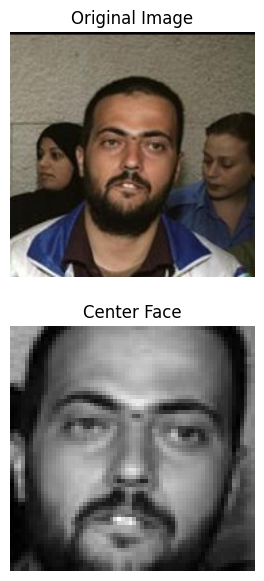

In [3]:
import cv2
import numpy as np

def get_center_face(image_path,target_size=(64, 64)):
    # load the picture 
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # load the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # detect faces
    faces = face_cascade.detectMultiScale(image)
    
    if len(faces) == 0:
        # print(image_path, 'no face detected') 
        return None

    image = gray
    # calculate the center of the image
    img_center = np.array([image.shape[1] // 2, image.shape[0] // 2])

    # find the closest face to the center
    closest_face = None
    min_distance = float('inf')
    
    for (x, y, w, h) in faces:
        face_center = np.array([x + w // 2, y + h // 2])
        distance = np.linalg.norm(face_center - img_center)
        
        if distance < min_distance:
            min_distance = distance
            closest_face = (x, y, w, h)
    
    # crop the face
    x, y, w, h = closest_face
    center_face = image[y:y+h, x:x+w]

    if center_face is not None:
        center_face = cv2.resize(center_face, target_size)
    
    return center_face

Image_path = 'lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg'
original = cv2.imread(Image_path)
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
center_face = get_center_face(Image_path)
plt.subplot(2, 1, 2)
plt.imshow(center_face, cmap='gray')
plt.title('Center Face')
plt.axis('off')
plt.show()


In [27]:
from tqdm import tqdm
def process_lfw_data(dataset_path):
    features_test = []
    labels_test = []
    features = []
    labels = []
    Names = []
    label = 0

    persons = [person for person in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, person))]
    none_face = 0
    for person in tqdm(persons, desc="Processing persons"):
        person_path = os.path.join(dataset_path, person)
        if not os.path.isdir(person_path):
            continue

        images = os.listdir(person_path)
        image_num = 0
        for img_name in images:
            img_path = os.path.join(person_path, img_name)
            face = get_center_face(img_path)
            if face is None:
                none_face += 1
                continue
            if face is not None:
                if image_num > 80:
                    features_test.append(face)
                    labels_test.append(label)
                else:
                    features.append(face)
                    labels.append(label)
                image_num += 1
        Names.append(person)
        label += 1

    features = np.array(features)  # 自动变为 (n, 64, 64)
    labels = np.array(labels)
    Names = np.array(Names)
    features_test = np.array(features_test)
    labels_test = np.array(labels_test)
    Detect_rate = (len(persons) - none_face) / len(persons)

    return features,labels, Names, features_test, labels_test, Detect_rate

dataset_path = 'lfw'
X, y, Names, X_test, y_test, Detect_rate = process_lfw_data(dataset_path)
print(X.shape)
print(y.shape)
print(Names.shape)
print(X_test.shape)
print(y_test.shape)
print(Detect_rate)

Processing persons:   4%|▍         | 249/5749 [00:07<02:15, 40.72it/s]

lfw/Andy_Roddick/Andy_Roddick_0010.jpg no face detected


Processing persons:  10%|▉         | 558/5749 [00:15<02:09, 40.11it/s]

lfw/Tom_McClintock/Tom_McClintock_0001.jpg no face detected


Processing persons:  11%|█         | 616/5749 [00:17<04:29, 19.02it/s]

lfw/Taia_Balk/Taia_Balk_0001.jpg no face detected


Processing persons:  15%|█▌        | 878/5749 [00:26<01:52, 43.15it/s]

lfw/Vecdi_Gonul/Vecdi_Gonul_0001.jpg no face detected


Processing persons:  18%|█▊        | 1026/5749 [00:30<03:50, 20.51it/s]

lfw/Igor_Ivanov/Igor_Ivanov_0007.jpg no face detected


Processing persons:  20%|██        | 1172/5749 [00:35<02:26, 31.29it/s]

lfw/Roy_Halladay/Roy_Halladay_0001.jpg no face detected


Processing persons:  24%|██▍       | 1392/5749 [00:43<02:27, 29.58it/s]

lfw/Jerry_Rice/Jerry_Rice_0001.jpg no face detected


Processing persons:  31%|███▏      | 1798/5749 [01:01<02:18, 28.47it/s]

lfw/John_Howard/John_Howard_0008.jpg no face detected


Processing persons:  34%|███▍      | 1949/5749 [01:05<01:20, 47.02it/s]

lfw/Klaus_Schwab/Klaus_Schwab_0001.jpg no face detected


Processing persons:  36%|███▋      | 2088/5749 [01:09<02:07, 28.75it/s]

lfw/Dereck_Whittenburg/Dereck_Whittenburg_0001.jpg no face detected


Processing persons:  44%|████▍     | 2528/5749 [01:22<01:08, 46.71it/s]

lfw/Brian_Schneider/Brian_Schneider_0001.jpg no face detected


Processing persons:  44%|████▍     | 2551/5749 [01:23<01:04, 49.55it/s]

lfw/Billy_Andrade/Billy_Andrade_0001.jpg no face detected


Processing persons:  50%|█████     | 2902/5749 [01:34<01:47, 26.53it/s]

lfw/Budd_Schulberg/Budd_Schulberg_0001.jpg no face detected


Processing persons:  53%|█████▎    | 3075/5749 [01:42<02:44, 16.28it/s]

lfw/Tung_Chee-hwa/Tung_Chee-hwa_0001.jpg no face detected


Processing persons:  56%|█████▌    | 3219/5749 [01:46<01:13, 34.57it/s]

lfw/George_P_Bush/George_P_Bush_0001.jpg no face detected


Processing persons:  58%|█████▊    | 3320/5749 [01:49<01:03, 38.01it/s]

lfw/Ronald_Ito/Ronald_Ito_0001.jpg no face detected


Processing persons:  61%|██████    | 3485/5749 [01:54<01:23, 27.16it/s]

lfw/Charles_Mathews/Charles_Mathews_0002.jpg no face detected


Processing persons:  62%|██████▏   | 3540/5749 [01:56<00:59, 37.08it/s]

lfw/Colin_Powell/Colin_Powell_0227.jpg no face detected


Processing persons:  67%|██████▋   | 3831/5749 [02:09<01:22, 23.22it/s]

lfw/Jelena_Dokic/Jelena_Dokic_0004.jpg no face detected


Processing persons:  74%|███████▍  | 4252/5749 [02:21<00:40, 36.69it/s]

lfw/John_Bolton/John_Bolton_0008.jpg no face detected


Processing persons:  76%|███████▌  | 4360/5749 [02:26<00:42, 32.78it/s]

lfw/Jennifer_Capriati/Jennifer_Capriati_0008.jpg no face detected


Processing persons:  80%|███████▉  | 4578/5749 [02:34<00:29, 40.26it/s]

lfw/Jim_Furyk/Jim_Furyk_0004.jpg no face detected


Processing persons:  83%|████████▎ | 4758/5749 [02:41<00:28, 34.24it/s]

lfw/Lucio_Gutierrez/Lucio_Gutierrez_0011.jpg no face detected


Processing persons:  85%|████████▍ | 4879/5749 [02:47<00:39, 22.15it/s]

lfw/Yasser_Arafat/Yasser_Arafat_0007.jpg no face detected
lfw/Yasser_Arafat/Yasser_Arafat_0005.jpg no face detected


Processing persons:  86%|████████▋ | 4969/5749 [02:50<00:37, 20.95it/s]

lfw/Vicente_Fox/Vicente_Fox_0020.jpg no face detected


Processing persons:  88%|████████▊ | 5039/5749 [03:00<00:19, 35.92it/s]

lfw/Silvio_Berlusconi/Silvio_Berlusconi_0015.jpg no face detected


Processing persons:  90%|█████████ | 5189/5749 [03:05<00:16, 32.95it/s]

lfw/Serena_Williams/Serena_Williams_0002.jpg no face detected


Processing persons:  92%|█████████▏| 5300/5749 [03:10<00:11, 40.81it/s]

lfw/Keith_Bogans/Keith_Bogans_0001.jpg no face detected


Processing persons:  95%|█████████▍| 5459/5749 [03:14<00:07, 39.59it/s]

lfw/Pele/Pele_0001.jpg no face detected


Processing persons:  98%|█████████▊| 5636/5749 [03:20<00:02, 45.51it/s]

lfw/Newt_Gingrich/Newt_Gingrich_0001.jpg no face detected


Processing persons:  99%|█████████▉| 5696/5749 [03:23<00:01, 31.11it/s]

lfw/Tom_Gamboa/Tom_Gamboa_0001.jpg no face detected


Processing persons: 100%|██████████| 5749/5749 [03:25<00:00, 27.99it/s]

(12467, 64, 64)
(12467,)
(5749,)
(734, 64, 64)
(734,)


In [ ]:
# define a function to extract HOG features
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for image in images:
        # calculate HOG features
        features = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False
        )
        hog_features.append(features)
    return np.array(hog_features)

# extract HOG features
X_hog = extract_hog_features(X)
X_test_hog = extract_hog_features(X_test)


HOG 特征形状: (12467, 1764)


In [ ]:

# use PCA to reduce the dimensionality of the HOG features
X_train = X_hog
X_test = X_test_hog
y_train = y
y_test = y_test
pca = PCA(n_components=0.95, whiten=True, random_state=42)  # keep 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA shape: {X_train_pca.shape}")



PCA 后训练集形状: (12467, 483)
y形状: (12467,)


In [7]:
# 训练 SVM 分类器
svm = SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.001, random_state=42)
svm.fit(X_train_pca, y_train)

# 在测试集上进行预测
y_pred = svm.predict(X_test_pca)

# 评估性能
print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")


分类报告:
              precision    recall  f1-score   support

         336       0.00      0.00      0.00         0
         613       0.00      0.00      0.00         0
         626       0.00      0.00      0.00         0
         811       0.00      0.00      0.00         0
         897       0.00      0.00      0.00         0
         926       0.00      0.00      0.00         0
        1015       0.00      0.00      0.00         0
        1139       0.00      0.00      0.00         0
        1279       0.00      0.00      0.00         0
        1381       0.00      0.00      0.00         0
        1392       0.70      0.68      0.69        28
        1528       0.00      0.00      0.00         0
        1554       0.83      0.78      0.80        63
        1693       0.00      0.00      0.00         0
        1794       0.00      0.00      0.00         0
        1830       0.00      0.00      0.00         0
        2021       0.00      0.00      0.00         0
        2234       0.

/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import dlib
import numpy as np
import cv2

# load the pre-trained models
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

# define a function to extract features
def extract_features(data):
    features = []

    for i, face in enumerate(data):
        # convert the image to RGB
        face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)

        rect = dlib.rectangle(left=0, top=0, right=63, bottom=63)

        # detect the face landmarks
        landmarks = predictor(face_rgb, rect)

        # compute the face descriptor
        face_descriptor = face_rec_model.compute_face_descriptor(face_rgb, landmarks)

        # append the face descriptor to the features list
        features.append(np.array(face_descriptor))

        if i % 500 == 0:
            print(f"Processed {i}/{len(data)} images.")

    features_array = np.array(features)

    print("Feature extraction complete. Shape:", features_array.shape)
    return features_array

features = extract_features(X)
features_test = extract_features(X_test)

Processed 0/12467 images.
Processed 500/12467 images.
Processed 1000/12467 images.
Processed 1500/12467 images.
Processed 2000/12467 images.
Processed 2500/12467 images.
Processed 3000/12467 images.
Processed 3500/12467 images.
Processed 4000/12467 images.
Processed 4500/12467 images.
Processed 5000/12467 images.
Processed 5500/12467 images.
Processed 6000/12467 images.
Processed 6500/12467 images.
Processed 7000/12467 images.
Processed 7500/12467 images.
Processed 8000/12467 images.
Processed 8500/12467 images.
Processed 9000/12467 images.
Processed 9500/12467 images.
Processed 10000/12467 images.
Processed 10500/12467 images.
Processed 11000/12467 images.
Processed 11500/12467 images.
Processed 12000/12467 images.
Feature extraction complete. Shape: (12467, 128)
Processed 0/734 images.
Processed 500/734 images.
Feature extraction complete. Shape: (734, 128)
分类报告:
              precision    recall  f1-score   support

         529       0.00      0.00      0.00       0.0
         613 

/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_test = scaler.transform(features_test)
svm = SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.001, random_state=42)
svm.fit(features, y_train)

# 在测试集上进行预测
y_pred = svm.predict(features_test)

# 评估性能
print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")

分类报告:
              precision    recall  f1-score   support

        1291       0.00      0.00      0.00         0
        1392       1.00      1.00      1.00        28
        1554       1.00      0.98      0.99        63
        3014       1.00      1.00      1.00        40
        3060       0.00      0.00      0.00         0
        3309       0.00      0.00      0.00         0
        3541       1.00      1.00      1.00       154
        4003       0.00      0.00      0.00         0
        4691       0.00      0.00      0.00         0
        4982       1.00      0.99      1.00       449

    accuracy                           0.99       734
   macro avg       0.50      0.50      0.50       734
weighted avg       1.00      0.99      1.00       734

准确率: 0.99


/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
